# 6.1 Episodic Memory

In the previous chapters, learning was based on gradually adjusting weights in a neural network. However, humans have the ability to learn from a single experience without the need for repetition. One could argue that this "one-shot" learning can be achieved by a high learning rate. However, a high learning rate can lead to *catastrophic forgetting*, where the network forgets previously learned associations.

Consider for example, the [Rumelhart Semantic Network](https://princetonuniversity.github.io/NEU-PSY-502/content/502B/Computation/Statistical%20Learning%20and%20Backpropagation/notebooks/1%20Rumelhart%20Semantic%20Network.html) from the previous chapter. If we first train the network to associate various birds with flying, and then train the network with a single example of a penguin with a very high learning rate, the network will forget the previous association with birds and flying. In general, we can mitigate this problem by using interleaved training, where we mix examples from the bird-category with the penguin example. However, this doesn't reflect human learning, where we can learn from a single example without forgetting previous associations.

[McClelland et al, 1995](https://princetonuniversity.github.io/NEU-PSY-502/_static/pdf/Class%2013/McClellandEtAl1995.pdf) proposed two complemantary learning systems: A slow learning system that learns gradually from repetition (in form of weight adjustments in the Neocortex) and a fast learning system that learns from single experiences (in form of episodic memory in the hippocampus). Here, we will explore how such a episodic memory system can be modeled in PsyNeuLink.

**Installation and Setup**
> If the following code fails, you might have to restart the kernel/session and run it again. This is a known issue when installing PsyNeulink in google colab.

In [32]:
import random

from psyneulink.library.models.Cohen_Huston1994 import threshold
%%capture
%pip install psyneulink
%pip install torch

import psyneulink as pnl
from torch import nn
import torch
import matplotlib.pyplot as plt

UsageError: Line magic function `%%capture` not found.


Episodic Memory - Torch Implementation

Here, we implement a simple episodic memory module using PyTorch. The module stores a set of keys and values. When queried with a key, it returns a weighted sum of the values, where the weights are determined by the similarity between the query key and the stored key.

In [129]:
def safe_softmax(t, threshold=0.001, **kwargs):
    """
    Softmax function that masks out values below a threshold.
    """

    v = t

    # Apply mask: only include values greater than mask_threshold
    v = torch.where(abs(v) > threshold, v, torch.tensor(-torch.inf, device=v.device))

    # Shift by the global max to avoid extreme values (numerical stability
    v = v - torch.max(v)

    # Exponentiate
    masked_exp = torch.exp(v)

    # Normalize (to sum to 1)
    if not masked_exp.any():
        return masked_exp
    else:
        return masked_exp / torch.sum(masked_exp)


class EMModule(nn.Module):
    """
    The EM module is a key-value memory that stores a set of keys and values.
    When queried with a key, it returns a weighted sum of the values, where the weights
    are determined by the similarity between the query key and the stored keys.
    """

    def __init__(self) -> None:
        super().__init__()
        # Current index to store the next key-value pair to
        self.index = 0

        # Keys and values to store
        self.keys = None
        self.values = None

    def get_match_weights(self, key: torch.tensor) -> torch.tensor:
        """
        Get the matched weights between the provided key and the stored keys, using the dot product.
        """
        return torch.einsum('b a, c a -> c b', self.keys, key)

    def forward(self, key: torch.tensor) -> torch.tensor:
        """
        Get the weighted sum of the stored values, using the provided key.
        """
        matched_weights = self.get_match_weights(key)
        return torch.einsum('a b, c a -> c b', self.values, safe_softmax(matched_weights, dim=-1))

    def prep(self, key, value):
        """
        Prepare the memory by setting the keys and values.
        """
        if self.keys is None:
            self.keys = key
        else:
            self.keys = torch.cat((self.keys, key), dim=0)
        if self.values is None:
            self.values = value
        else:
            self.values = torch.cat((self.values, value), dim=0)

    def reset(self):
        """
        Reset the memory by setting the keys and values to None.
        """
        self.keys = None
        self.values = None
        self.index = 0

    def write(self, key, value):
        """
        Write a key-value pair to the memory.
        """
        if self.keys is None:
            self.keys = key
        else:
            self.keys[self.index] = key
        if self.values is None:
            self.values = value
        else:
            self.values[self.index] = value
        self.index += 1

Let's inspect the EMModule class to understand how it works:

In [130]:
em = EMModule()

def plot(em_module):
        # Plot keys
    if em.keys is not None:
        plt.figure(figsize=(8, 4))
        plt.imshow(em_module.keys.detach().numpy(), cmap='viridis', aspect='auto')
        plt.colorbar(label="Key Value")
        plt.title("Keys Heatmap")
        plt.xlabel("Features")
        plt.ylabel("Memory Slots")
        plt.show()
    else:
        print(
            "No keys found in the memory. Please add keys before plotting.")

    # Plot values
    if em_module.values is not None:
        plt.figure(figsize=(8, 4))
        plt.imshow(em_module.values.detach().numpy(), cmap='viridis', aspect='auto')
        plt.colorbar(label="Value")
        plt.title("Values Heatmap")
        plt.xlabel("Features")
        plt.ylabel("Memory Slots")
        plt.show()
    else:
        print(
            "No values found in the memory. Please add values before plotting.")


plot(em)

No keys found in the memory. Please add keys before plotting.
No values found in the memory. Please add values before plotting.


 Let's start by adding some empty key and value pairs to the memory. Here, we assume both keys and values are one-hot encoded (categorical) vectors. Here, we use 5-dimensional vetors and initialize the memory with 10 key-value pairs filled with 0.001:

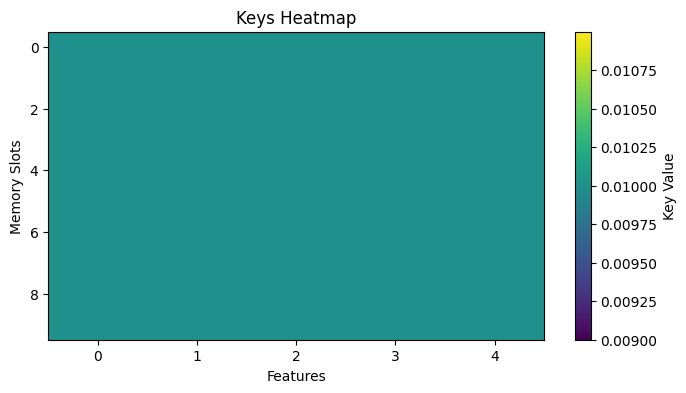

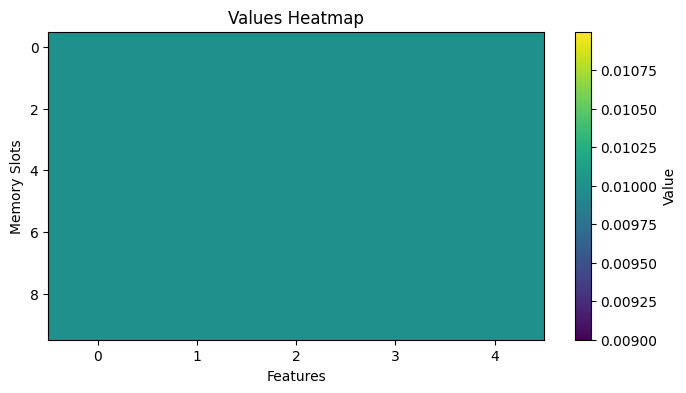

In [131]:
memory_capacity = 10

em.reset()

for _ in range(memory_capacity):
    em.prep(torch.tensor([[.01] * 5], dtype=torch.float),
            torch.tensor([[.01] * 5], dtype=torch.float))

plot(em)

All the keys and values are initialized with 0.001. Let's add a key-value pair by adding it to the memory:

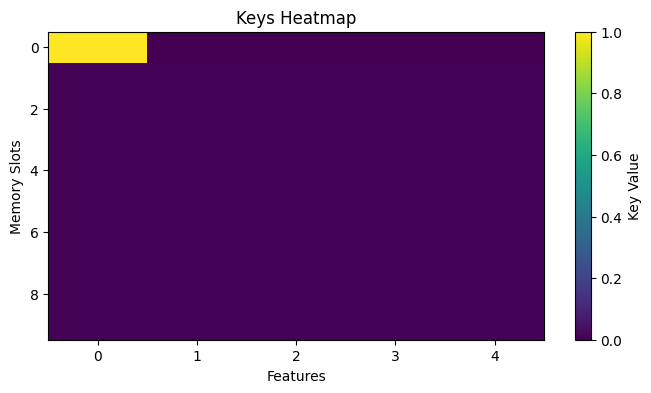

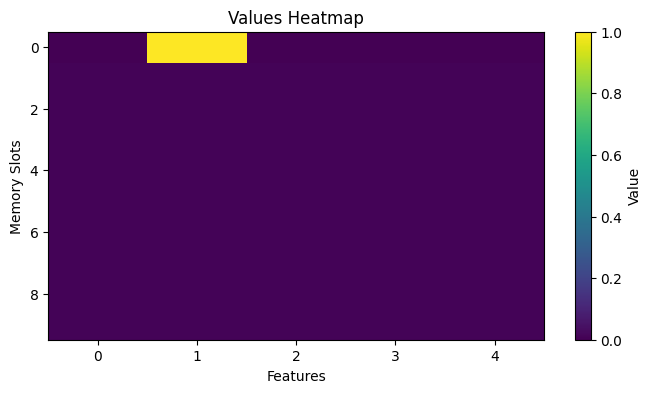

In [132]:
em.write(torch.tensor([1, 0, 0, 0, 0], dtype=torch.float), torch.tensor([0, 1, 0, 0, 0], dtype=torch.float))
plot(em)

We can see, that for both the keys and the values, the first memory slot has been updated. Let's see what happens when we query the memory:

In [133]:
res = em.forward(torch.tensor([[1, 0, 0, 0, 0]], dtype=torch.float))
print(res)

tensor([[0.0077, 0.2379, 0.0077, 0.0077, 0.0077]])


Note, while the returned value has the highest value at the second entry, it is not the exact value we stored. Let's explore what is going on. The memory first matches the query key with the stored keys. But how exactly does it do that? Let's inspect the match weights:

In [134]:
memorized_keys = em.keys
query_key = torch.tensor([[1, 0, 0, 0, 0]], dtype=torch.float)

match_weights = torch.einsum('b a, c a -> c b', memorized_keys, query_key)
print(match_weights)

tensor([[1.0000, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
         0.0100]])


`torch.einsum('b a, c a -> c b', memorized_keys, query_key)` calculates the dot product between the query key and each stored key. The result is a 1x10 vector that indicates the "overlap" between the query key and each stored key. Since the first entry of keys is the same as the query key (both `[1, 0, 0, 0, 0]` the dot product is 1.0. The other entries have a dot product of `0.001` since the memory was initialized with this value.


In the next step, we calculate the softmax of the math weight. This normalizes the match weights to sum to 1.0.


In [135]:
match_weights_sm = safe_softmax(match_weights, dim=-1)
print(match_weights_sm)

tensor([[0.2302, 0.0855, 0.0855, 0.0855, 0.0855, 0.0855, 0.0855, 0.0855, 0.0855,
         0.0855]])


Here, we see that the softmax "flattens" the vector while keeping the highest value at the first entry.

To retreive the memory, we use another einsum by multiplying the stored memory values (`em.values`) with the match_weights. This results in a weighted sum of the stored values, where the weights are determined by the similarity between the query key and the stored key for each memory slot:

In [136]:
retrieved_value = torch.einsum('a b, c a -> c b', em.values, match_weights_sm)
print(retrieved_value)

tensor([[0.0077, 0.2379, 0.0077, 0.0077, 0.0077]])



<h0 style="background: #256ca2; color: #e9e9e9">🎯 Exercise 1</h0>
    

The above implementation of the softmax masks values below a certain threshold. Why is this necessary? What would happen if we didn't mask values?
    


<details><summary style="background: #d6c89d; color: #e9e9e9">💡 Hint </summary>
    

In our toy example we have only a few memory slots. However, in a most scenarios, we want to model a large number of episodic memory slots. In this case, the `match_weight` vector will have a large number of entries with a lot of zeros (or near zeros). Think about why that is problematic.
    
</details>
    


<details><summary style='background: #22ae6a; color:#e9e9e9'>✅ Solution 1</summary>
    

The "flattening" effect of the softmax function is dependent on the length of the vector. For example, try running the following code:

```python
res = safe_softmax(torch.tensor([1] + [0.01] * 10), threshold=0.001 )
res_2 = safe_softmax(torch.tensor([1] + [0.01] * 100), threshold=0.001)
print(res[0])
print(res_2[0])

res_safe_1 = safe_softmax(torch.tensor([1] + [0.01] * 10), threshold=0.01)
res_safe_2 = safe_softmax(torch.tensor([1] + [0.01] * 100), threshold=0.01)
print(res_safe_1[0])
print(res_safe_2[0])
```

    
</details>
    


<h0 style="background: #256ca2; color: #e9e9e9">🎯 Exercise 2</h0>
    

Try playing around with the threshold value in the `safe_softmax` function. Can you find a threshold value that results in memory retrieval that is closer to the stored value?
    


<h0 style="background: #256ca2; color: #e9e9e9">🎯 Exercise 3</h0>
    

Try adding more key-value pairs to the memory. How does the memory retrieval change with more key-value pairs?
    

 ## PsyNeuLink - EMComposition

`PsyNeuLink` provides build-in support for episodic memory through the `EMComposition`. Here, we explain the most important parameters of the `EMComposition`. It can be used to easily build more complex memory structures, and we will use it in the [next tutorial](https://princetonuniversity.github.io/NEU-PSY-502/content/502B/Computation/Episodic%20Memory/notebooks/2%20Episodic%20Generalization%20Optimization%20-%20EGO.html) in the EGO model.

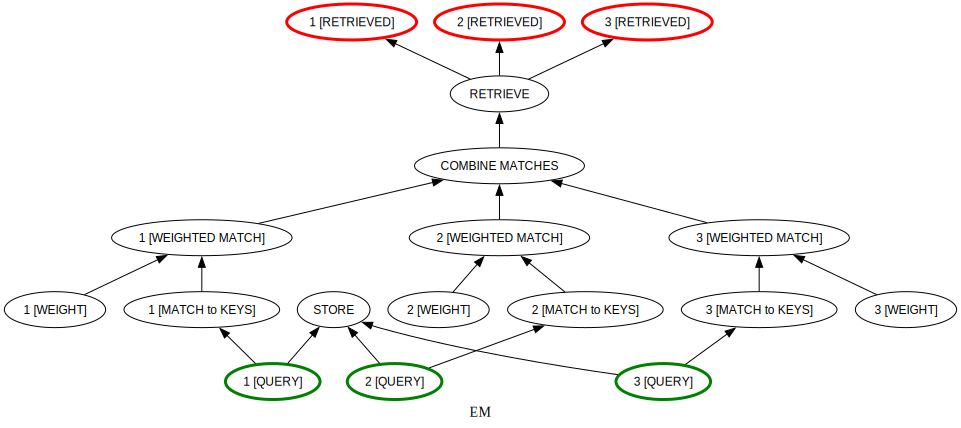

In [137]:
em = pnl.EMComposition(name='EM',  # name
                       memory_capacity=1000,  # number of key-value pairs
                       memory_template=[[0, 0], [0, 0, 0, 0], [0, 0, 0]],
                       # template for the memory. Note: Here we use 3 memory slots (instead of just a key value pair, we can store as many keys and pairs as we want.)
                       fields={'1':
                                   {pnl.FIELD_WEIGHT: .33,
                                    # weight of the key. This determines how much this "slot" influences the retrieval
                                    pnl.LEARN_FIELD_WEIGHT: False,  # The weight can be learned via backpropagation
                                    pnl.TARGET_FIELD: False
                                    # If this is a target field, the error is calculated here, and backpropagated
                                    },
                               '2': {pnl.FIELD_WEIGHT: .33,
                                     pnl.LEARN_FIELD_WEIGHT: False,
                                     pnl.TARGET_FIELD: False},
                               '3': {pnl.FIELD_WEIGHT: .33,
                                     pnl.LEARN_FIELD_WEIGHT: False,
                                     pnl.TARGET_FIELD: False},

                               },
                       memory_fill=.001,  # fill the memory with this value
                       normalize_memories=True,  # normalize the memories
                       softmax_gain=1.,  # gain of the softmax function
                       softmax_threshold=0.1,  # threshold of the softmax function
                       memory_decay=0,  # memory can be decayed over time
                       )
em.show_graph(output_fmt='jupyter')

The above figure seems complicated at first, but it follows the same principle as the torch implementation:
We look it from the bottom to the top:
- The arrows from the 1, 2, and 3 query to the "STORE" node, represent that these values are stored in memory
- All of them ara also passed through a "MATCH" node, wich calculates the similarity between the query and the stored values (just as desibed above for the keys)
- The "MATCH" nodes are then weighted and combined. (Here they are also softmaxed)
- Then the result is used to retrieve the memory by multiplying the "combined matchse" with the stored values.


<h0 style="background: #256ca2; color: #e9e9e9">🎯 Exercise 4</h0>
    

In our implementation, we specified input node 1 as having 2 entries (1x2 vector), the input node 2 with 4 entries (1x4 vector), and the input node 3 with 3 entries (1x3 vector). Yet, In the explanation above, I talked about adding weighted vectors together. How can that be?
    


<details><summary style="background: #d6c89d; color: #e9e9e9">💡 Hint </summary>
    
We are not adding the query vectors together but the matched weights. What is the shape of these weights?
    
</details>
    


<details><summary style='background: #22ae6a; color:#e9e9e9'>✅ Solution 4</summary>
    

The matched weights have the shape of the number of memory slots. Their entries don't represent the query vectors themselves, the `i`-th entry signifies how similar the memory in slot `i` is to the query vector.

This is why a weighted sum makes sense, we are literally weighing how similar 1, 2, and 3 is and then combining them. This way the retrieavel searches for the most combined (weighted) similarity
    
</details>
    

### Marking a Field as Value (non-query)

If we don't want specific fields to be taken into account on retrieval (for example if they are the "target" fields that the model is supposed to predict), we can set their retrieval weight to "None":

em.memory

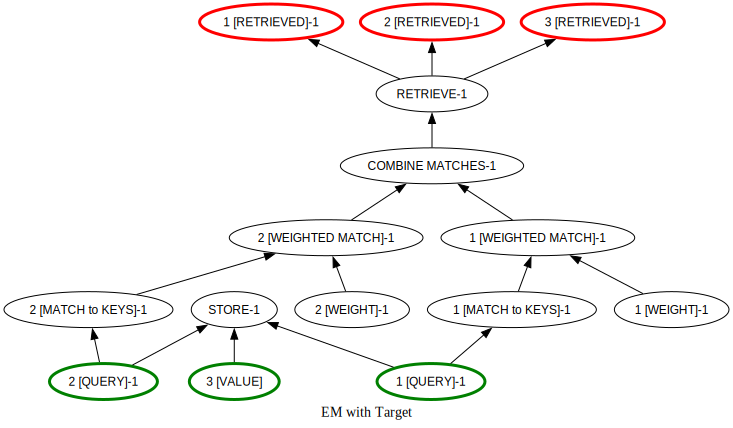

In [138]:
em = pnl.EMComposition(name='EM with Target',  # name
                       memory_capacity=1000,  # number of key-value pairs
                       memory_template=[[0, 0], [0, 0, 0, 0], [0, 0, 0]],
                       # template for the memory. Note: Here we use 3 memory slots (instead of just a key value pair, we can store as many keys and pairs as we want.)
                       fields={'1':
                                   {pnl.FIELD_WEIGHT: .5,
                                    # weight of the key. This determines how much this "slot" influences the retrieval
                                    pnl.LEARN_FIELD_WEIGHT: False,  # The weight can be learned via backpropagation
                                    pnl.TARGET_FIELD: False
                                    # If this is a target field, the error is calculated here, and backpropagated
                                    },
                               '2': {pnl.FIELD_WEIGHT: .5,
                                     pnl.LEARN_FIELD_WEIGHT: False,
                                     pnl.TARGET_FIELD: False},
                               '3': {pnl.FIELD_WEIGHT: None,
                                     pnl.LEARN_FIELD_WEIGHT: False,
                                     pnl.TARGET_FIELD: True},

                               },
                       memory_fill=.001,  # fill the memory with this value
                       normalize_memories=True,  # normalize the memories
                       softmax_gain=1.,  # gain of the softmax function
                       softmax_threshold=0.1,  # threshold of the softmax function
                       memory_decay=0,  # memory can be decayed over time
                       )
em.show_graph(output_fmt='jupyter')

As you see, this way 3 is stored (and retrieved) but is not taken into account when calculating the matched similarity (it is not "used" to retrieve from memory).